In [1]:
import sys
sys.setrecursionlimit(15000)

import torch
import torch.nn.functional as F
from torch import nn
import numpy as np

BATCH_SIZE = 5
NUM_CLASSES = 3
NUM_EPOCHS = 100
NUM_ROUTING_ITERATIONS = 3


In [2]:
def softmax(input, dim=1):
    transposed_input = input.transpose(dim, len(input.size()) - 1)
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input.size()) - 1)



In [3]:
def squash(x, dim=-1):
    squared_norm = (x**2).sum(dim=dim, keepdim=True)
    out = (squared_norm * x) / ((1 + squared_norm) * torch.sqrt(squared_norm))
    return out

class PrimaryCaps(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_capsules):
        super(PrimaryCaps, self).__init__()
        self.capsules = nn.ModuleList()
        
        for i in range(num_capsules):
            self.capsules.append(nn.Conv2d(in_channels, out_channels, 9, stride=2))
            
    def forward(self, x):
        out = []
        for cap in self.capsules:
            out.append(cap(x))

        out = torch.stack(out, dim=1)
        out = out.view(x.size()[0], len(self.capsules), -1)
        out = out.permute(0,2,1)
        out = squash(out, dim=-1)
        
        return out
    
class ClassesCaps(torch.nn.Module):
    def __init__(self, in_channels, out_channels, in_vectors, n_capsules, n_iters):
        super(ClassesCaps, self).__init__()
        
        self.weights = nn.Parameter(torch.randn(n_capsules, in_vectors, in_channels, out_channels))
        self.n_iters = n_iters
        
        self.in_vectors = in_vectors
        self.n_capsules = n_capsules
        
    def forward(self, x):
        predictions = x[None, :, :, None, :] @ self.weights[:, None, :, :, :]
        predictions = predictions.squeeze(3)
        predictions = predictions.permute(2,0,1,3)
        
        
#         print('predictions', predictions.shape)
        B = Variable(torch.zeros(self.in_vectors, self.n_capsules, x.shape[0])).cuda()
#         print('B', B.shape)
        
        for i in range(self.n_iters):
            C = torch.nn.Softmax(dim=0)(B)
#             print('C', C.shape)
            S = (predictions*C[:,:,:,None]).sum(dim=0, keepdim=True)
#             print('S', S.shape)
            S = squash(S, dim=3)
            

            if i != self.n_iters - 1:
                B_del = (predictions*S).sum(dim=-1)
#                 print('B_del', B_del.shape)
                B = B + B_del
                
        S = S.squeeze(0)
        S = S.permute(1,0,2)
        return S

In [4]:
class Decoder(torch.nn.Module):    
    def __init__(self, in_features, n_classes, img_height, img_width):
        super(Decoder, self).__init__()
        self.shape = (img_height, img_width)
        out_features = img_height * img_width
        seq = []
        seq.append(nn.Linear(in_features*n_classes, 512))
        seq.append(nn.ReLU())
        seq.append(nn.Linear(512, 1024))
        seq.append(nn.ReLU())
        seq.append(nn.Linear(1024, img_height*img_width))
        seq.append(nn.Sigmoid())
        
        self.pipe = nn.Sequential(*seq)
        
    def forward(self, x):
        x = self.pipe(x)
#         x = x.view(x.shape[0], *self.shape)
        return(x)

In [5]:
class CapsuleNet(nn.Module):
    def __init__(self, height, width, prim_channels=256, el_decoded=784, sec_side=6):
        super(CapsuleNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=prim_channels, kernel_size=9, stride=1)

        
        self.primary_capsules = PrimaryCaps(in_channels=prim_channels, out_channels=32, num_capsules=8)

        self.digit_capsules = ClassesCaps(in_channels=8, out_channels=16, in_vectors=32 * sec_side * sec_side, 
                                              n_capsules=NUM_CLASSES, n_iters=NUM_ROUTING_ITERATIONS)

        self.decoder = Decoder(in_features=16, n_classes=NUM_CLASSES, img_height=height, img_width=width)

    def forward(self, x, y=None):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primary_capsules(x)
        
        x = self.digit_capsules(x)
        x = x.squeeze(2).squeeze(2)
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        


        if y is None:
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.sparse.torch.eye(NUM_CLASSES)).cuda().index_select(dim=0, index=max_length_indices)

        reconstructions = self.decoder((x * y[:, :, None]).view(x.size(0), -1))

        return classes, reconstructions

In [6]:
class CapsuleLoss(nn.Module):
    def __init__(self):
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average=False)

    def forward(self, images, labels, classes, reconstructions):
        left = F.relu(0.9 - classes, inplace=True) ** 2
        right = F.relu(classes - 0.1, inplace=True) ** 2

        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        assert torch.numel(images) == torch.numel(reconstructions)
        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)

In [11]:
from torch.autograd import Variable
from torch.optim import Adam
from torchnet.engine import Engine
from torchnet.logger import VisdomPlotLogger, VisdomLogger
from torchvision.utils import make_grid
from torchvision.datasets.mnist import MNIST
from tqdm import tqdm
import torchnet as tnt

model = CapsuleNet(64, 64, 64, 4096, 24)
# model = CapsuleNet()
# model.load_state_dict(torch.load('epochs/epoch_327.pt'))
model.cuda()

print("# parameters:", sum(param.numel() for param in model.parameters()))

# parameters: 13159296


In [12]:
optimizer = Adam(model.parameters())

engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()
meter_accuracy = tnt.meter.ClassErrorMeter(accuracy=True)
confusion_meter = tnt.meter.ConfusionMeter(NUM_CLASSES, normalized=True)

train_loss_logger = VisdomPlotLogger('line', opts={'title': 'Train Loss'})
train_error_logger = VisdomPlotLogger('line', opts={'title': 'Train Accuracy'})
test_loss_logger = VisdomPlotLogger('line', opts={'title': 'Test Loss'})
test_accuracy_logger = VisdomPlotLogger('line', opts={'title': 'Test Accuracy'})
confusion_logger = VisdomLogger('heatmap', opts={'title': 'Confusion matrix',
                                                 'columnnames': list(range(NUM_CLASSES)),
                                                 'rownames': list(range(NUM_CLASSES))})
ground_truth_logger = VisdomLogger('image', opts={'title': 'Ground Truth'})
reconstruction_logger = VisdomLogger('image', opts={'title': 'Reconstruction'})

capsule_loss = CapsuleLoss()

In [13]:
import h5py
from sklearn.model_selection import train_test_split

f = h5py.File('h5.mat')

images = np.expand_dims(f['image'][()], axis=1)
masks = f['tumorMask'][()]
labels = f['label'][()].astype(np.int32)

data_train, data_test, labels_train, labels_test, masks_train, masks_test = train_test_split(images, labels, masks, shuffle=True)



def get_iterator(mode):
#     dataset = MNIST(root='./data', download=True, train=mode)
#     data = getattr(dataset, 'train_data' if mode else 'test_data')
#     labels = getattr(dataset, 'train_labels' if mode else 'test_labels')   
    
    if mode:
        data = torch.FloatTensor(data_train)
        labels = torch.LongTensor(labels_train)
    else:
        data = torch.FloatTensor(data_test)
        labels = torch.LongTensor(labels_test)

    
    tensor_dataset = tnt.dataset.TensorDataset([data, labels])

    return tensor_dataset.parallel(batch_size=BATCH_SIZE, num_workers=4, shuffle=mode)


def processor(sample):
    data, labels, training = sample

#     data = (data.unsqueeze(1).float() / 255.0)
    data = (data.float())
    labels = torch.LongTensor(labels)
    


    labels = torch.sparse.torch.eye(NUM_CLASSES).index_select(dim=0, index=labels)

    data = Variable(data).cuda()
    labels = Variable(labels).cuda()

#     print(data.shape)
#     print(type(data.data))
#     print(labels.shape)
#     print(type(labels.data))
    
    if training:
        classes, reconstructions = model(data, labels)
    else:
        classes, reconstructions = model(data)
        
#     print(classes.shape)
#     print(type(classes.data))
#     print(classes[0])
#     print(reconstructions.shape)
#     print(type(reconstructions.data))

    loss = capsule_loss(data, labels, classes, reconstructions)

    return loss, classes

In [14]:
def reset_meters():
    meter_accuracy.reset()
    meter_loss.reset()
    confusion_meter.reset()


def on_sample(state):
    state['sample'].append(state['train'])


def on_forward(state):
    meter_accuracy.add(state['output'].data, torch.LongTensor(state['sample'][1]))
    confusion_meter.add(state['output'].data, torch.LongTensor(state['sample'][1]))
    meter_loss.add(state['loss'].data[0])


def on_start_epoch(state):
    reset_meters()
    state['iterator'] = tqdm(state['iterator'])

In [15]:
def on_end_epoch(state):
    print('[Epoch %d] Training Loss: %.4f (Accuracy: %.2f%%)' % (
        state['epoch'], meter_loss.value()[0], meter_accuracy.value()[0]))

#     train_loss_logger.log(state['epoch'], meter_loss.value()[0])
#     train_error_logger.log(state['epoch'], meter_accuracy.value()[0])

    reset_meters()

    engine.test(processor, get_iterator(False))
#     test_loss_logger.log(state['epoch'], meter_loss.value()[0])
#     test_accuracy_logger.log(state['epoch'], meter_accuracy.value()[0])
#     confusion_logger.log(confusion_meter.value())

    print('[Epoch %d] Testing Loss: %.4f (Accuracy: %.2f%%)' % (
        state['epoch'], meter_loss.value()[0], meter_accuracy.value()[0]))

#     torch.save(model.state_dict(), 'epochs/epoch_%d.pt' % state['epoch'])

    # Reconstruction visualization.

#     test_sample = next(iter(get_iterator(False)))

#     print()
#     ground_truth = test_sample[0].float()
#     _, reconstructions = model(Variable(ground_truth).cuda())
#     reconstruction = reconstructions.cpu().view_as(ground_truth).data

#     ground_truth_logger.log(
#         make_grid(ground_truth, nrow=int(BATCH_SIZE ** 0.5), normalize=True, range=(0, 1)).numpy())
#     reconstruction_logger.log(
#         make_grid(reconstruction, nrow=int(BATCH_SIZE ** 0.5), normalize=True, range=(0, 1)).numpy())

# def on_start(state):
#     state['epoch'] = 327
#
# engine.hooks['on_start'] = on_start



engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epoch

engine.train(processor, get_iterator(True), maxepoch=NUM_EPOCHS, optimizer=optimizer)

100%|██████████| 460/460 [00:33<00:00, 13.79it/s]

[Epoch 1] Training Loss: 0.3265 (Accuracy: 58.22%)



  0%|          | 0/460 [00:00<?, ?it/s]

[Epoch 1] Testing Loss: 0.2856 (Accuracy: 62.40%)


100%|██████████| 460/460 [00:32<00:00, 13.98it/s]

[Epoch 2] Training Loss: 0.2657 (Accuracy: 68.28%)



  0%|          | 0/460 [00:00<?, ?it/s]

[Epoch 2] Testing Loss: 0.2515 (Accuracy: 68.41%)


 37%|███▋      | 171/460 [00:12<00:20, 13.90it/s]Process Process-20:
Traceback (most recent call last):
  File "/home/dolorousrtur/anaconda3/envs/dipstereo/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process Process-18:
Process Process-17:
  File "/home/dolorousrtur/anaconda3/envs/dipstereo/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-19:
  File "/home/dolorousrtur/anaconda3/envs/dipstereo/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/dolorousrtur/anaconda3/envs/dipstereo/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/dolorousrtur/anaconda3/envs/dipstereo/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/dolorousrtur/anaconda3/envs/d

KeyboardInterrupt: 

 37%|███▋      | 171/460 [00:30<00:50,  5.69it/s]

In [ ]:
from utils import tumor_data_np

test_data = tumor_data_np(data_test, labels_test)
test_feeder = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

correct, y_pred, y_true = 0, list(), list()

for image, labels in test_feeder:
    
    labels = torch.LongTensor(labels.long())
    labels = torch.sparse.torch.eye(NUM_CLASSES).index_select(dim=0, index=labels.squeeze())

    data = Variable(image).float().cuda()
    labels = Variable(labels).cuda()
    

    
    classes, reconstructions = model(data)
    
    pred = np.argmax(classes.data.cpu().numpy(), axis=1)
    true = np.argmax(labels.data.cpu().numpy(), axis=1)
    
    
    correct += (pred == true).sum()
    y_pred.append(pred)
    y_true.append(true)
    
print('Accuracy:', correct/len(test_data))

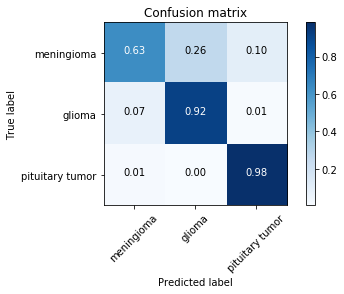

In [15]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

plot_confusion_matrix(cm=confusion_matrix(y_true, y_pred), classes=['meningioma','glioma','pituitary tumor'])